In [1]:
import pandas as pd, numpy as np, os
csv_path = "/kaggle/input/eeg-brainwave-dataset-feeling-emotions/emotions.csv"
assert os.path.exists(csv_path), f"Not found: {csv_path}"
df = pd.read_csv(csv_path)
print(df.shape); print(df.columns.tolist()[:40])

# Pick target column robustly for this dataset
candidate_labels = ['label','emotion','liked','predefinedlabel','valence','arousal','dominance','target','class']
y_name = next((c for c in candidate_labels if c in map(str.lower, df.columns)), None)
if y_name is None:
    # try exact-case fallback
    y_name = next((c for c in candidate_labels if c in df.columns), None)
assert y_name is not None, f"No label column found in {candidate_labels}. Columns: {list(df.columns)[:30]}"
# normalize to actual case
y_name = [c for c in df.columns if c.lower()==y_name][0]

# drop obvious non-signal ID/meta columns if present
drop_meta = [c for c in ['id','user','gender','age','experiment_id','video'] if c in df.columns]
X = df.drop(columns=[y_name] + drop_meta)
y = df[y_name].astype(str)
print("Using label:", y_name, "| dropped meta:", drop_meta, "| X shape:", X.shape)


(2132, 2549)
['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a', 'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a', 'mean_d_0_a2', 'mean_d_1_a2', 'mean_d_2_a2', 'mean_d_3_a2', 'mean_d_4_a2', 'mean_d_5_a', 'mean_d_6_a', 'mean_d_7_a', 'mean_d_8_a', 'mean_d_9_a', 'mean_d_10_a', 'mean_d_11_a', 'mean_d_12_a', 'mean_d_13_a', 'mean_d_14_a', 'mean_d_15_a', 'mean_d_16_a', 'mean_d_17_a', 'mean_d_18_a', 'mean_d_19_a', 'mean_d_20_a', 'mean_d_21_a', 'mean_d_22_a', 'mean_d_23_a', 'mean_d_24_a', 'mean_d_25_a', 'mean_d_26_a', 'mean_d_27_a', 'mean_d_28_a', 'mean_d_29_a']
Using label: label | dropped meta: [] | X shape: (2132, 2548)


Classes: {'NEUTRAL': 0.336, 'NEGATIVE': 0.332, 'POSITIVE': 0.332} | n_features: 2548
Cols with >5% NaN: []


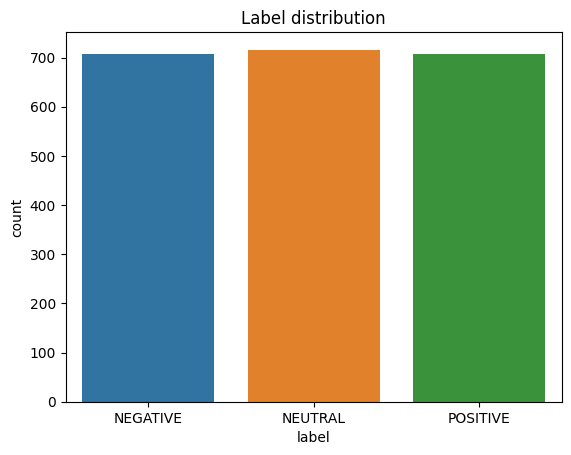

In [2]:
import seaborn as sns, matplotlib.pyplot as plt
df = df.dropna(axis=1, how='all')  # drop empty cols
# Try to locate label column
label_cols = [c for c in df.columns if c.lower() in ['label','emotion','target','class']]
assert len(label_cols)>=1, "Could not find a label column named label/emotion/target/class."
y_name = label_cols[0]
y = df[y_name].astype(str)
X = df.drop(columns=[y_name])

print("Classes:", y.value_counts(normalize=True).round(3).to_dict(), "| n_features:", X.shape[1])

# Missing values
mv = X.isna().mean()
print("Cols with >5% NaN:", mv[mv>0.05].index.tolist()[:10])
X = X.fillna(X.median(numeric_only=True))

# Quick label bar
sns.countplot(x=y); plt.title("Label distribution"); plt.show()


In [3]:
# Heuristic: many columns with channel-like names or integer-step suffixes => time-series-like
def looks_like_timeseries(cols):
    hits = 0
    for c in cols[:2000]:
        if any(ch in c.upper() for ch in ['AF','F','FC','T','P','O']) and any(ch.isdigit() for ch in c):
            hits += 1
        elif c.strip().split('_')[-1].isdigit():
            hits += 1
    return hits > 50 or X.shape[1] > 1000

is_timeseries = looks_like_timeseries(list(X.columns))
print("Time-series-like:", is_timeseries)

Time-series-like: True


In [4]:
from scipy.signal import butter, filtfilt, iirnotch, welch

def butter_bandpass(low, high, fs, order=4):
    b,a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return b,a

def apply_notch(x, fs=128.0, f0=50.0, Q=30.0):
    b,a = iirnotch(f0/(fs/2), Q)
    return filtfilt(b,a, x)

def bandpowers(psd_f, psd_pxx, bands):
    out={}
    for name,(lo,hi) in bands.items():
        idx = (psd_f>=lo) & (psd_f<=hi)
        out[name] = np.trapz(psd_pxx[idx], psd_f[idx])
    return out

def to_3d_timeseries(Xdf, fs_guess=128.0):
    # Assume columns grouped per channel over time, try reshape by equal-length segments.
    cols = Xdf.columns
    # Infer per-row time length by greatest common divisor of column count across likely channel counts
    guess_chs = [8,14,19,32,64]
    nfeat = Xdf.shape[1]
    for ch in guess_chs:
        if nfeat % ch == 0:
            T = nfeat//ch
            return Xdf.values.reshape(len(Xdf), ch, T), ch, T, fs_guess
    # fallback: treat as 1 channel series
    return Xdf.values.reshape(len(Xdf), 1, nfeat), 1, nfeat, fs_guess

if is_timeseries:
    X3, n_ch, T, fs = to_3d_timeseries(X)
    print(f"Assumed shape: (n={X3.shape[0]}, ch={n_ch}, T={T}), fs≈{fs} Hz")

    # Filter + notch
    bp_b, bp_a = butter_bandpass(1.0, 45.0, fs, order=4)
    Xf = np.empty_like(X3, dtype=float)
    for i in range(X3.shape[0]):
        for c in range(n_ch):
            sig = X3[i,c].astype(float)
            try:
                sig = filtfilt(bp_b, bp_a, sig)
                sig = apply_notch(sig, fs=fs, f0=50.0, Q=30.0)
            except Exception:
                pass
            Xf[i,c] = sig

    # Bandpowers per channel
    bands = {"delta":(1,4),"theta":(4,8),"alpha":(8,13),"beta":(13,30),"gamma":(30,45)}
    feats = []
    for i in range(Xf.shape[0]):
        row = {}
        for c in range(n_ch):
            f, pxx = welch(Xf[i,c], fs=fs, nperseg=min(256, T))
            bp = bandpowers(f, pxx, bands)
            for bname,val in bp.items():
                row[f"ch{c}_{bname}"] = val
        feats.append(row)
    X_feat = pd.DataFrame(feats).replace([np.inf,-np.inf], np.nan).fillna(0.0)
else:
    X_feat = X.copy()

Assumed shape: (n=2132, ch=14, T=182), fs≈128.0 Hz


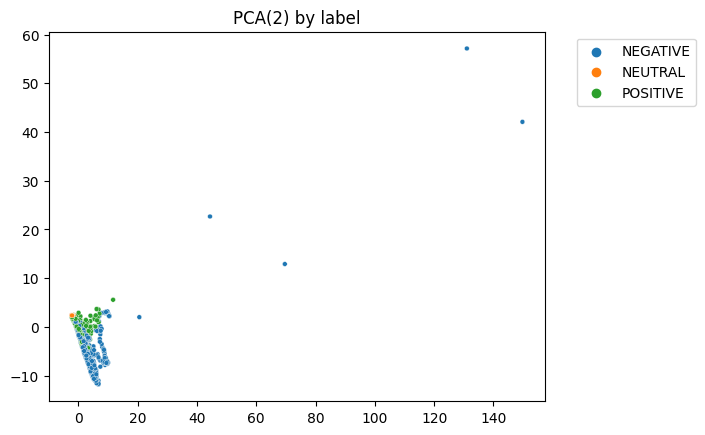

2025-10-05 05:16:03.051486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759641363.308656      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759641363.382515      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


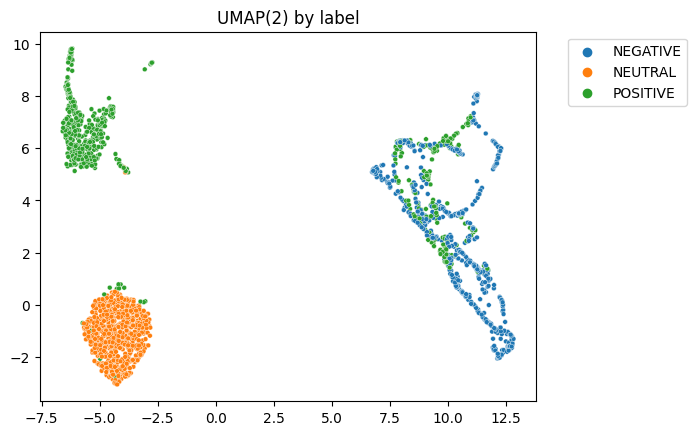

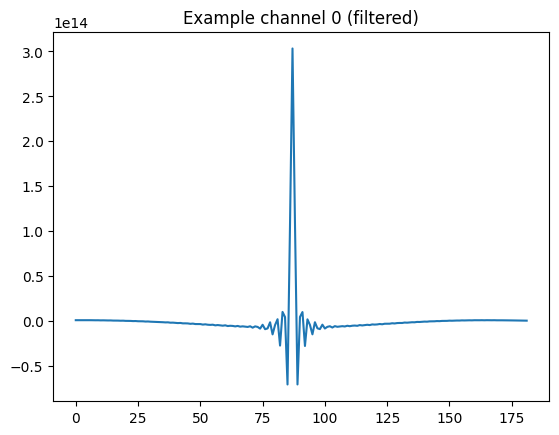

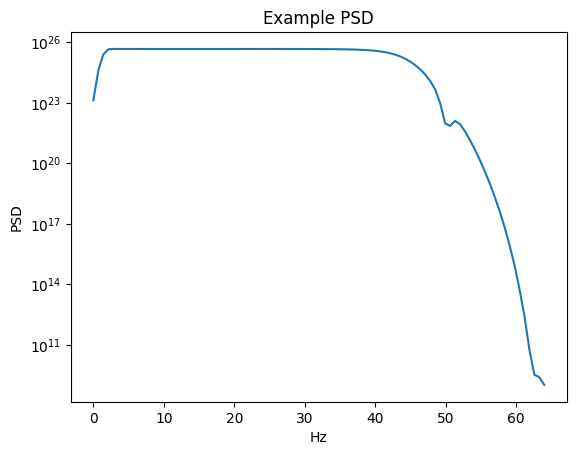

In [5]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
Xz = StandardScaler().fit_transform(X_feat)

# PCA scatter
pca = PCA(n_components=2, random_state=0).fit_transform(Xz)
plt.figure(); sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=y, s=12)
plt.title("PCA(2) by label"); plt.legend(bbox_to_anchor=(1.05,1)); plt.show()

# UMAP scatter
import umap
um = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=0).fit_transform(Xz)
plt.figure(); sns.scatterplot(x=um[:,0], y=um[:,1], hue=y, s=12)
plt.title("UMAP(2) by label"); plt.legend(bbox_to_anchor=(1.05,1)); plt.show()

# If time-series: plot an example trace and PSD
if is_timeseries:
    i0 = 0
    fig,ax=plt.subplots(); 
    ax.plot(Xf[i0,0]); ax.set_title("Example channel 0 (filtered)"); plt.show()
    f,pxx = welch(Xf[i0,0], fs=fs, nperseg=min(256,T))
    plt.figure(); plt.semilogy(f,pxx); plt.title("Example PSD"); plt.xlabel("Hz"); plt.ylabel("PSD"); plt.show()

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
classes = le.classes_
print("Classes:", list(classes))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Classes: ['NEGATIVE', 'NEUTRAL', 'POSITIVE']


[XGBoost] 5-fold Acc: 0.974 ± 0.007 | F1w: 0.974
Confusion matrix:
 [[687   0  21]
 [  0 716   0]
 [ 32   3 673]]


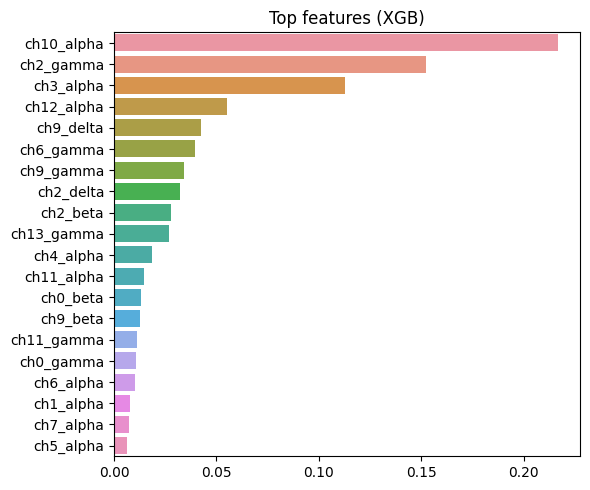

In [7]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np

def cv_eval_model(model, X, y, skf): #cross validation function
    accs, f1s = [], []
    cms = np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int)
    for tr,te in skf.split(X,y):
        model.fit(X[tr], y[tr])
        yp = model.predict(X[te])
        accs.append(accuracy_score(y[te], yp))
        f1s.append(f1_score(y[te], yp, average='weighted'))
        cms += confusion_matrix(y[te], yp, labels=np.unique(y))
    return np.mean(accs), np.std(accs), np.mean(f1s), cms
#Performs 5-fold stratified cross-validation:
#Splits data into 5 parts maintaining class balance.
#Trains on 4 parts, tests on 1.
#Records accuracy, weighted F1, and confusion matrix per fold.
#Returns their averages

Xn = X_feat.values.astype(np.float32) #data preparation
#Converts the features (X_feat) into a NumPy array of type float32, which most ML libraries use.

xgb_clf = xgb.XGBClassifier(
    n_estimators=400, max_depth=6, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
    tree_method="hist", random_state=42
)
acc_mu, acc_sd, f1_mu, cm = cv_eval_model(xgb_clf, Xn, y_enc, skf) #Trains and evaluates the model.
#Outputs mean accuracy ± std and average F1 score.
print(f"[XGBoost] 5-fold Acc: {acc_mu:.3f} ± {acc_sd:.3f} | F1w: {f1_mu:.3f}")
print("Confusion matrix:\n", cm)

#This builds an XGBoost model — an ensemble of decision trees trained via gradient boosting.
#Each tree corrects the mistakes of the previous ones.

# Feature importance plot (top 20)
importances = xgb_clf.fit(Xn, y_enc).feature_importances_
idx = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(6,5))
sns.barplot(x=importances[idx], y=np.array(X_feat.columns)[idx])
plt.title("Top features (XGB)"); plt.tight_layout(); plt.show()
#Retrains XGBoost once on all data to extract feature importances and plots the top 20.
#Helps identify which EEG features most strongly drive the emotion prediction.

[XGBoost] 5-fold Acc: 0.974 ± 0.007 | F1w: 0.974
[RandomForest] 5-fold Acc: 0.972 ± 0.006 | F1w: 0.972
[SVM (RBF)] 5-fold Acc: 0.339 ± 0.003 | F1w: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/skle

[LogisticRegression] 5-fold Acc: 0.332 ± 0.001 | F1w: 0.166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 1705, number of used features: 70
[LightGBM] [Info] Start training from score -1.102726
[LightGBM] [Info] Start training from score -1.090435
[LightGBM] [Info] Start training from score -1.102726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

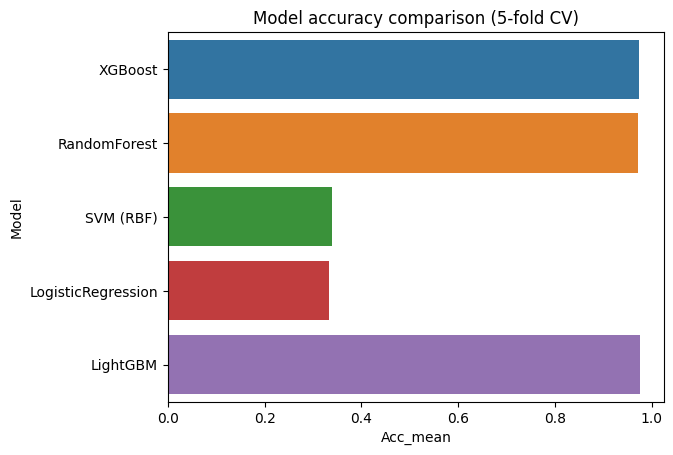

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

models = {
    "XGBoost": xgb.XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, random_state=42, tree_method="hist"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    ),
    "SVM (RBF)": SVC(kernel='rbf', C=1.0, gamma='scale'),
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=400, learning_rate=0.05, num_leaves=31, random_state=42
    )
}

results = []
for name, model in models.items():
    acc_mu, acc_sd, f1_mu, cm = cv_eval_model(model, Xn, y_enc, skf)
    results.append((name, acc_mu, acc_sd, f1_mu))
    print(f"[{name}] 5-fold Acc: {acc_mu:.3f} ± {acc_sd:.3f} | F1w: {f1_mu:.3f}")

# Summarize
results_df = pd.DataFrame(results, columns=["Model","Acc_mean","Acc_std","F1_weighted"])
print("\nModel comparison:\n", results_df.sort_values("Acc_mean", ascending=False))
sns.barplot(x="Acc_mean", y="Model", data=results_df)
plt.title("Model accuracy comparison (5-fold CV)")
plt.show()
